In [6]:
%reload_ext autoreload
%autoreload 2

# Add parent directory for NPLinker imports
import sys
sys.path.append('..')

# scoring functions for strain correspondence
import scoring_functions

In [2]:
path = "/home/grimur/Downloads/specbgc/"

In [3]:
import csv
import numpy
import os

In [7]:
population_size = 25

for file in os.listdir(path):
    filepath = path + file
    outpath = "/home/grimur/Downloads/specbgc-update/" + file
    lines = []
    with open(filepath, 'r') as f:
        r = csv.reader(f, delimiter="\t")
        header = next(r)
        header.append('metcalf_expected')
        header.append('metcalf_variance')
        header.append('metcalf_standardised')
        for l in r:
            spec = int(l[4])
            gcf = int(l[5])
            overlap = int(l[6])
            l[7] = population_size
            l[9] = None
            metcalf_expected, metcalf_variance = scoring_functions.metcalf_expected_count(spec, gcf, overlap, population_size, 10, -10, 0, 1)
            metcalf_raw = scoring_functions.metcalf_count(spec, gcf, overlap, population_size, 10, -10, 0, 1)
            metcalf_standardised = (metcalf_raw - metcalf_expected) / numpy.sqrt(metcalf_variance)

            l.append(metcalf_expected)
            l.append(metcalf_variance)
            l.append(metcalf_standardised)
            l[8] = metcalf_raw

            lines.append(l)

    lines.sort(key=lambda x: x[-1], reverse=True)
            
    with open(outpath, 'w') as fw:
        w = csv.writer(fw, delimiter="\t")
        w.writerow(header)
        for l in lines:
            w.writerow(l)

In [11]:
from scoring import metcalf_expected_count

ImportError: cannot import name 'metcalf_expected_count' from 'scoring' (/home/grimur/git/nplinker/nplinker/prototype/scoring/__init__.py)

In [21]:
spectra_file = "/home/grimur/data-carnegie/data-nplinker/Carnegie_mzmineoutputmgf_quant.csv"

In [37]:
ions_membership = {}
with open(spectra_file, 'r') as f:
    r = csv.reader(f)
    header = next(r)
    for l in r:
        spectrum_id = l[0]
        signal = [x.split('.')[0] for x, y in zip(header[:-1], l[:-1]) if float(y) > 0.0 and x.startswith('KRD')]
        ions_membership[spectrum_id] = signal

In [44]:
membership_by_media = {}
for ion, signal in ions_membership.items():
    for signal_id in signal:
        signal_id_parts = signal_id.split('_')
        medium = signal_id_parts[-1].upper()
        strain = ''.join(signal_id_parts[:-1])
        if medium not in membership_by_media:
            membership_by_media[medium] = {}
        if ion not in membership_by_media[medium]:
            membership_by_media[medium][ion] = []
        membership_by_media[medium][ion].append(strain)

In [ ]:
bigscape_dir = "/home/grimur/data-carnegie/data-nplinker/bigscape"

In [71]:
cutoff = '30'

strains = set()

gcfs = {}
for product_type in os.listdir(bigscape_dir):
    if product_type.endswith('.tsv'):
        continue
    for filename in os.listdir(os.path.join(bigscape_dir, product_type)):
        if not ('cluster' in filename and cutoff in filename):
            continue
        path = os.path.join(bigscape_dir, product_type, filename)
        with open(path, 'r') as f:
            for l in f.readlines():
                if l.startswith('#'):
                    continue
                bgc_id, product_family_id = l.strip().split()
                # ??????
                family_id = product_type + product_family_id
                #family_id = product_family_id
                if family_id not in gcfs:
                    gcfs[family_id] = []
                strain = bgc_id.split('.')[0]
                gcfs[family_id].append(strain)
                
                strains.add(strain)

In [77]:
import _scoring as scoring
import numpy

In [86]:
scores_by_medium = {}

for medium, spectra in membership_by_media.items():
    scores_by_medium[medium] = []
    for spectrum, spectrum_strains in spectra.items():
        for gcf, gcf_strains in gcfs.items():
            spectrum_strain_count = len(strains.intersection(spectrum_strains))
            gcf_strain_count = len(gcf_strains)
            strain_count = len(strains)
            overlap = len(set(spectrum_strains).intersection(gcf_strains))
            
            metcalf_raw = scoring.metcalf_count(spectrum_strain_count, gcf_strain_count, overlap, strain_count, 10, -10, 0, 1)
            metcalf_exp, metcalf_var = scoring.metcalf_expected_count(spectrum_strain_count, gcf_strain_count, overlap, strain_count, 10, -10, 0, 1)
            metcalf_std = (metcalf_raw - metcalf_exp) / numpy.sqrt(metcalf_var)
            scores_by_medium[medium].append((metcalf_raw, metcalf_std))

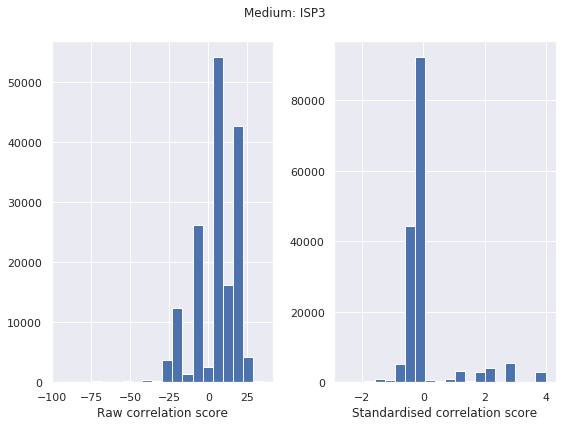

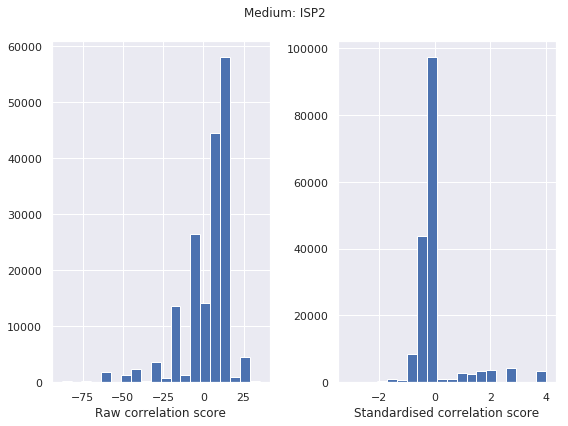

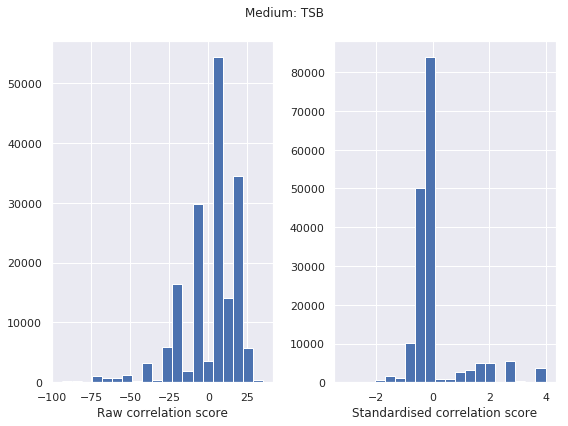

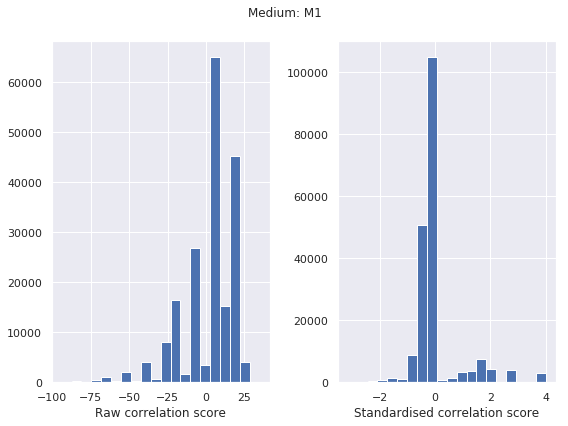

In [104]:
for medium, scores in scores_by_medium.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    fig.suptitle('Medium: {}'.format(medium))
    
    ax1.hist([x[0] for x in scores], bins=20)
    ax1.set_xlabel('Raw correlation score')

    ax2.hist([x[1] for x in scores], bins=20)
    ax2.set_xlabel('Standardised correlation score')

    plt.tight_layout()
    
    fig.subplots_adjust(top=0.9)